# Data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from feature_engine.outliers import Winsorizer

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.3f}'.format
import warnings; warnings.filterwarnings('ignore')


In [4]:
# pd.DataFrame({'a':[np.nan,1,2,3,np.nan]}).ffill()

In [531]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
train['is_test'] = 0 ; test['is_test'] = 1

data = pd.concat((
        train,
        test)
        )\
    .reset_index(drop=True)\
    .assign(
        cfips = lambda df: df['cfips'].astype(str).str.zfill(5),
        date = lambda df: pd.to_datetime(df["first_day_of_month"]),
        m_density = lambda df: df['microbusiness_density'],
        )\
    .sort_values(['cfips','date'], ascending=True)\
    .assign(
        state_i = lambda df: df['cfips'].apply(lambda x: x[:2]),
        county_i = lambda df: df['cfips'].apply(lambda x: x[2:]),
        year = lambda df: df['date'].dt.year,
        month = lambda df: df['date'].dt.month,
        dcount = lambda df: df.groupby('cfips')['row_id'].cumcount(),
        m_density_lag_1 = lambda df: df.groupby('cfips')['m_density'].shift(1),
        target = lambda df: np.where(
            (df['m_density_lag_1']==0) | (df['m_density']==0),
            0,
            (df['m_density']/(df['m_density_lag_1'])).fillna(1).clip(0,99) - 1),
        # target2 = 2

        )\
    .drop(['row_id','first_day_of_month','county','state'], axis=1)\
    [['cfips','date','dcount','county_i','state_i','month','year','is_test','active','m_density','m_density_lag_1','target']]\
    # .sort_index(ascending=True)

        
assert all(data.groupby('cfips')['county_i'].nunique() == 1)
assert all(data.groupby('cfips')['state_i'].nunique() == 1)
assert data['cfips'].nunique() == 3135 # there are 3135 county,state tuples
assert data['dcount'].nunique() == 47 # there are 47 series for each county state tuple
assert data.query('is_test==0')['dcount'].nunique() == 39 # there are 39 series in the train set. 
assert data.query('is_test==1')['dcount'].nunique() == 8  # there are 8 series in the test set. 

#The private leaderboard will include 03-2023, 04-2023, 05-2023
#The public leaderboard includes the first month 11-2022. Probably it will be updated later as 12-2022,01-2023 and 02-2023


# Clean Outliers

In [532]:
# capper = 
capper = Winsorizer(capping_method='iqr',tail='both', fold=5)
data['target_capped'] = capper.fit_transform(data[['target']])

In [533]:
# # check
# data['target_ratio'] = data['target_ratio'].abs()
# data.groupby('dcount')['target_ratio'].sum().plot()

# data['target_ratio_capped_1'] = data['target_ratio_capped_1'].abs()
# data.groupby('dcount')['target_ratio_capped_1'].sum().plot()


In [534]:
# # check
# temp = data.groupby(['cfips']).agg({'target_ratio':['mean','median','std']})
# temp.columns = ['mean','median','std']
# temp['ratio'] = temp['std']/(temp['median']+1e-10)
# temp = temp.sort_values('std',ascending=False)

# LEVEL1,LEVEL2,LEVEL3 = 1,2,5
# capper = Winsorizer(capping_method='iqr',tail='both', fold=LEVEL1)
# data[f'target_ratio_clean_{LEVEL1}'] = capper.fit_transform(data[['target_ratio']])
# capper = Winsorizer(capping_method='iqr',tail='both', fold=LEVEL2)
# data[f'target_ratio_clean_{LEVEL2}'] = capper.fit_transform(data[['target_ratio']])
# capper = Winsorizer(capping_method='iqr',tail='both', fold=LEVEL3)
# data[f'target_ratio_clean_{LEVEL3}'] = capper.fit_transform(data[['target_ratio']])

# for i in range(0,20):
#     try:
#         plt.figure()
#         x = data[(data['cfips'] == temp.index[i]) & (data['is_test'] == 0)][['target_ratio',f'target_ratio_clean_{LEVEL1}',f'target_ratio_clean_{LEVEL2}',f'target_ratio_clean_{LEVEL3}']]
#         # plt.plot(x[['target_ratio']].values.reshape(-1, 1))
#         plt.plot(x[[f'target_ratio_clean_{LEVEL1}']].values.reshape(-1, 1),'--', label=f'{LEVEL1}')
#         plt.plot(x[[f'target_ratio_clean_{LEVEL2}']].values.reshape(-1, 1),'--', label=f'{LEVEL2}')
#         plt.plot(x[[f'target_ratio_clean_{LEVEL3}']].values.reshape(-1, 1),'--', label=f'{LEVEL3}')
#         plt.legend()
#     except Exception as e:
#         print(e)
#         print(i)

    


# Extra Data

In [535]:
# census_starter = pd.read_csv('./data/census_starter.csv')

# census_starter = census_starter.assign(
#     cfips = lambda x: x['cfips'].astype(str)
#     )\
#     .set_index(['cfips']).sort_index(ascending=True)

# colname_tuples = [('_'.join(e.split('_')[:-1]),e.split('_')[-1]) for e in census_starter.columns.tolist()]
# new_index = pd.MultiIndex.from_tuples(colname_tuples, names=['category','year_info'])
# census_starter = census_starter.set_axis(new_index, axis=1).stack(level=1)
# census_starter = census_starter.reset_index()
# census_starter['year_available'] = census_starter['year_info'].astype(int) + 2



# census_starter = pd.read_csv('./data/census_starter.csv')

# census_starter = census_starter.assign(
#     cfips = lambda x: x['cfips'].astype(str)
#     )\
#     .set_index(['cfips']).sort_index(ascending=True)

# new_index = pd.MultiIndex.from_tuples([('_'.join(e.split('_')[:-1]),e.split('_')[-1]) for e in census_starter.columns.tolist()], names=['category','year'])
# census_starter = census_starter.set_axis(new_index, axis=1).stack(level=1)
# mean_census = census_starter.groupby(level='year').mean()
# mean_census

# Cross validation

In [536]:
import numpy as np
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score

from mlxtend.evaluate.time_series import (
    GroupTimeSeriesSplit,
    plot_splits,
    print_cv_info,
    print_split_info,
)

In [557]:
sample = data[data.cfips.isin(['01001','56045'])]
sample.loc[sample.is_test==1,'target_capped']  = np.nan

sample = sample.set_index('date')
sample = sample.loc['2022-01':'2023-01']
sample = sample.sort_index()
sample = sample[['cfips','dcount', 'year','county_i','target_capped']]
# sample = sample.reset_index()
# sample = sample.sort_values('dcount').reset_index(drop=True)
sample

,cfips,dcount,year,county_i,target_capped
date,,,,,
2022-01-01,01001,29,2022,001,0.003
2022-01-01,56045,29,2022,045,-0.026
2022-02-01,01001,30,2022,001,0.011
2022-02-01,56045,30,2022,045,0.000
2022-03-01,01001,31,2022,001,0.001
2022-03-01,56045,31,2022,045,0.010
2022-04-01,01001,32,2022,001,0.011
2022-04-01,56045,32,2022,045,0.000
2022-05-01,01001,33,2022,001,-0.017


In [590]:
n = 1
sample[f'target_lag_{n}'] = sample.groupby('cfips')['target_capped'].shift(n)
sample[f'target_lag_{n}'] = sample.groupby('cfips')['target_capped'].shift(n)

sample

n = 2
sample


,cfips,dcount,year,county_i,target_capped,target_lag_1
date,,,,,,
2022-01-01,01001,29,2022,001,0.003,NaN
2022-01-01,56045,29,2022,045,-0.026,NaN
2022-02-01,01001,30,2022,001,0.011,0.003
2022-02-01,56045,30,2022,045,0.000,-0.026
2022-03-01,01001,31,2022,001,0.001,0.011
2022-03-01,56045,31,2022,045,0.010,0.000
2022-04-01,01001,32,2022,001,0.011,0.001
2022-04-01,56045,32,2022,045,0.000,0.010
2022-05-01,01001,33,2022,001,-0.017,0.011


In [583]:
sample_train= sample[sample['dcount']<39]
sample_test= sample[sample['dcount']>=39]

In [584]:
# cv_args = {"test_size": 1, "train_size": 2, 'gap_size':2}
cv_args = {"test_size": 1, "n_splits": 5, "train_size": 2, 'gap_size':0}

# plot_splits(sample, None, sample['dcount'], **cv_args)
# print_split_info(X, y, groups, **cv_args)

cv = GroupTimeSeriesSplit(**cv_args)
# for i1,i2 in cv:
#     print(i1)
for i, (train_index, val_index) in enumerate(cv.split(sample_train, sample_train['target_capped'], sample_train['dcount'] )):
    print(i)
    display(sample_train.iloc[train_index])
    display(sample_train.iloc[val_index])
    print('---')

0


,cfips,dcount,year,county_i,target_capped
date,,,,,
2022-04-01,01001,32,2022,001,0.011
2022-04-01,56045,32,2022,045,0.000
2022-05-01,01001,33,2022,001,-0.017
2022-05-01,56045,33,2022,045,0.020


,cfips,dcount,year,county_i,target_capped
date,,,,,
2022-06-01,01001,34,2022,001,0.010
2022-06-01,56045,34,2022,045,0.000


---
1


,cfips,dcount,year,county_i,target_capped
date,,,,,
2022-05-01,01001,33,2022,001,-0.017
2022-05-01,56045,33,2022,045,0.020
2022-06-01,01001,34,2022,001,0.010
2022-06-01,56045,34,2022,045,0.000


,cfips,dcount,year,county_i,target_capped
date,,,,,
2022-07-01,56045,35,2022,045,0.000
2022-07-01,01001,35,2022,001,0.027


---
2


,cfips,dcount,year,county_i,target_capped
date,,,,,
2022-06-01,01001,34,2022,001,0.010
2022-06-01,56045,34,2022,045,0.000
2022-07-01,56045,35,2022,045,0.000
2022-07-01,01001,35,2022,001,0.027


,cfips,dcount,year,county_i,target_capped
date,,,,,
2022-08-01,01001,36,2022,001,-0.004
2022-08-01,56045,36,2022,045,-0.010


---
3


,cfips,dcount,year,county_i,target_capped
date,,,,,
2022-07-01,56045,35,2022,045,0.000
2022-07-01,01001,35,2022,001,0.027
2022-08-01,01001,36,2022,001,-0.004
2022-08-01,56045,36,2022,045,-0.010


,cfips,dcount,year,county_i,target_capped
date,,,,,
2022-09-01,56045,37,2022,045,0.000
2022-09-01,01001,37,2022,001,0.005


---
4


,cfips,dcount,year,county_i,target_capped
date,,,,,
2022-08-01,01001,36,2022,001,-0.004
2022-08-01,56045,36,2022,045,-0.010
2022-09-01,56045,37,2022,045,0.000
2022-09-01,01001,37,2022,001,0.005


,cfips,dcount,year,county_i,target_capped
date,,,,,
2022-10-01,56045,38,2022,045,0.000
2022-10-01,01001,38,2022,001,0.006


---


In [ ]:
# test

In [452]:
small_data = [[0], [7], [6], [4], [4], [8], [0], [6], [2], [0], [5], [9], [7], [7], [7], [7]]
target = [1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0]

X = pd.DataFrame(small_data, columns=["num_feature"])
y = pd.Series(target, name="target")
groups = np.array([0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 5, 5])
months_map = {i: f"2021-0{i+1}" for i in range(6)}
months = np.array([months_map[group] for group in groups])
X = X.set_index(months)
# X

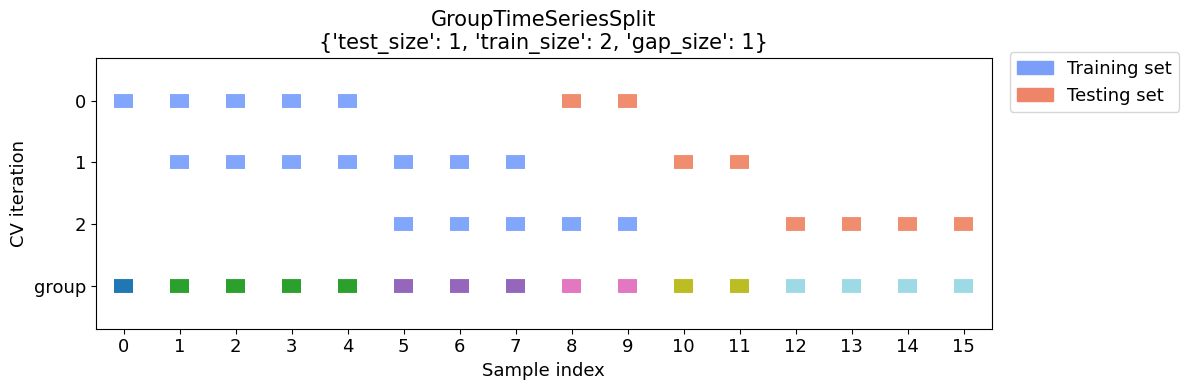

In [459]:
cv_args = {"test_size": 1, "train_size": 2, "gap_size":1}
# cv_args = {"test_size": 2, "n_splits": 3}

plot_splits(X, None, groups, **cv_args)
# print_split_info(X, y, groups, **cv_args)

In [438]:
# cv = GroupTimeSeriesSplit(**cv_args)
# clf = DummyClassifier(strategy="most_frequent")

# scores = cross_val_score(clf, X, y, groups=groups, scoring="accuracy", cv=cv)
# print_cv_info(cv, X, y, groups, clf, scores)